In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd

In [2]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 2


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE=IMAGE_SIZE[0]

# Carregar o dataset de treino completo (vai ser dividido)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Pré-processamento e performance
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Contar batches totais
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Dividir o dataset em treino (90%) e validação (10%)
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Carregar dataset de TESTE (a tua pasta separada)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Verificar tamanhos
print("Total batches:", total_batches+tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 1104 files belonging to 2 classes.
Found 301 files belonging to 2 classes.
Total batches: 45
Train batches: 31
Validation batches: 4
Test batches: 10


In [4]:

model = Sequential([
    # 1º bloco
    layers.Resizing(SIZE, SIZE, interpolation="bilinear", input_shape=(SIZE, SIZE, 3)),
    layers.Conv2D(96, kernel_size=11, strides=4, padding='same'),
    layers.Lambda(tf.nn.local_response_normalization),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # 2º bloco
    layers.Conv2D(256, kernel_size=5, strides=1, padding='same'),
    layers.Lambda(tf.nn.local_response_normalization),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # 3º bloco
    layers.Conv2D(384, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(384, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # Camadas densas
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


c:\Users\joaov\Desktop\programing\piton\TAA\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds                          # Validation dataset
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5013 - loss: 0.7125 - val_accuracy: 0.5000 - val_loss: 0.6884
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5047 - loss: 0.6950 - val_accuracy: 0.6172 - val_loss: 0.6464
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6066 - loss: 0.6576 - val_accuracy: 0.5938 - val_loss: 0.6624
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6608 - loss: 0.6431 - val_accuracy: 0.5703 - val_loss: 0.6540
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6756 - loss: 0.6125 - val_accuracy: 0.6250 - val_loss: 0.6231
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6864 - loss: 0.6106 - val_accuracy: 0.6875 - val_loss: 0.6270
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6942 - loss: 0.5713 - val_accuracy: 0.7422 - val_loss: 0.5270
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6966 - loss: 0.5744 - val_accuracy: 0.6562 - val_loss:

In [7]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

,accuracy,loss,val_accuracy,val_loss
5,0.694672,0.594366,0.687500,0.626983
6,0.694672,0.575545,0.742188,0.527032
7,0.716734,0.553516,0.656250,0.590886
8,0.706967,0.541802,0.741071,0.571827
9,0.731557,0.529586,0.773438,0.479239


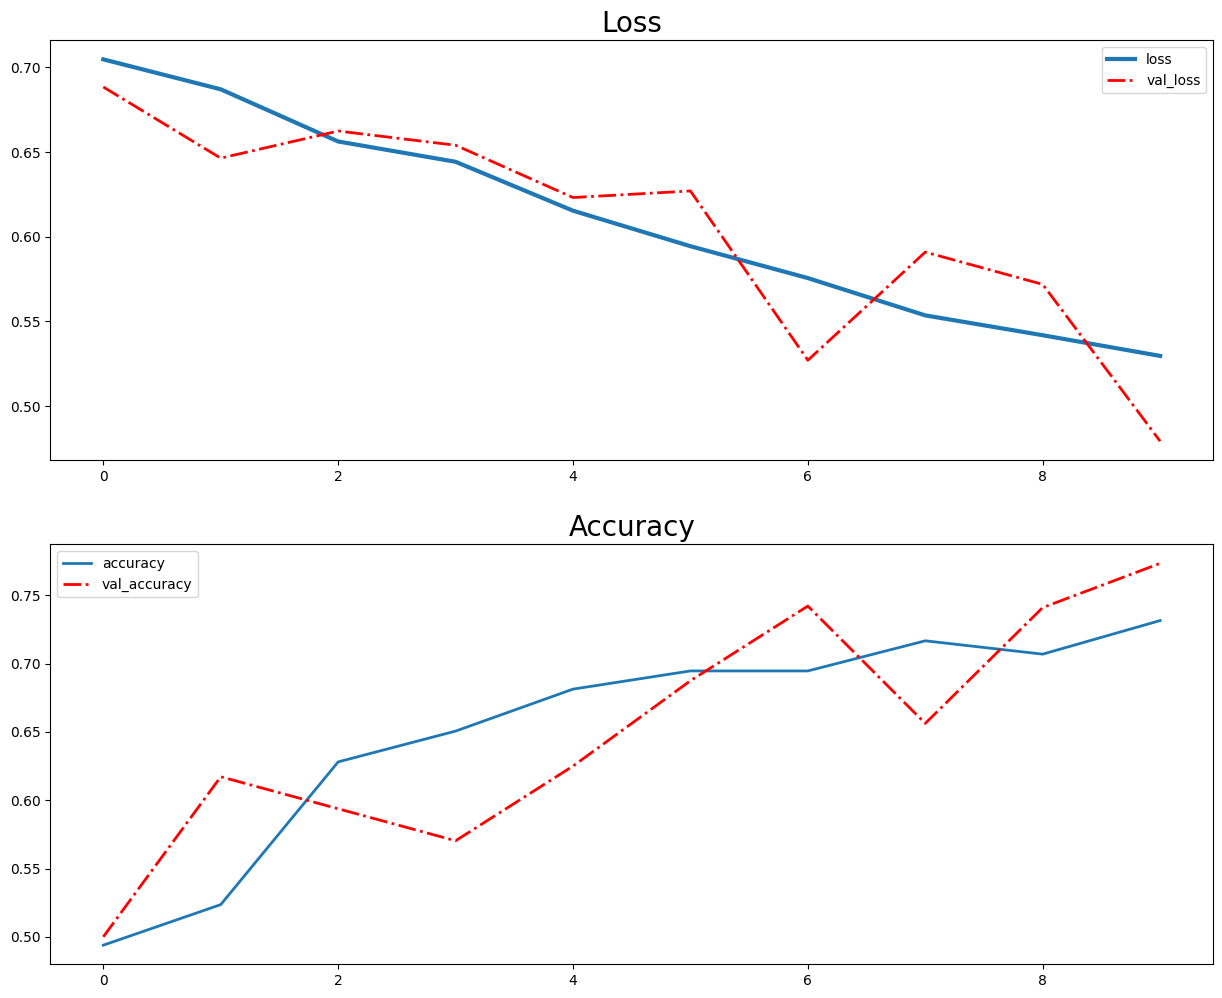

In [8]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [9]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [10]:
# Evaluate model by model.evaluate()
loss, accuracy = model.evaluate(test_ds)
print()
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.8656 - loss: 0.3373

Loss : 0.3707427382469177
Accuracy : 87.70763874053955%


In [ ]:
model.save("AlexNet_model.keras")